In [20]:
import tushare as ts

token = ''  # 设置tocken
pro = ts.pro_api(token)  # 初始化pro接口
# 获取数据
df_gldq = pro.daily(ts_code='000001.sz', start_date='20200101', end_date='20240126')

df_gldq.sort_values(by='trade_date', inplace=True)
# 打印数据
df_gldq.to_excel('stock.xls')


e:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  # Remove the CWD from sys.path while we load stuff.


In [22]:
import pandas as pd
import numpy as np
#数据处理
df = pd.read_excel("stock.xls")
print("原始数据的大小：", df.shape)
print("原始数据的列名", df.columns)

df['trade_date'] = pd.to_datetime(df['trade_date'])
df.reset_index(inplace=True, drop=False)
df.drop(['index', 'ts_code', 'open', 'high', 'low' , 'pre_close', 'change', 'pct_chg', 'amount'], axis=1, inplace=True)
#df['trade_date'] = df['trade_date'].apply(datetime.datetime.toordinal)
print(df.head())
dates = df['trade_date'][1:]
close_v = df['close']
volume = df['vol'][1:]
diff = np.diff(close_v)
#获得输入数据
X = np.column_stack([diff, volume])
print("输入数据的大小：", X.shape)   #(1504, 2)

min = X.mean(axis=0)[0] - 8*X.std(axis=0)[0]   #最小值
max = X.mean(axis=0)[0] + 8*X.std(axis=0)[0]  #最大值
X = pd.DataFrame(X)
#异常值设为均值
for i in range(len(X)):  #dataframe的遍历
    if (X.loc[i, 0]< min) | (X.loc[i, 0] > max):
            X.loc[i, 0] = X.mean(axis=0)[0]

#数据集的划分
X_Test = X.iloc[:-100]
X_Pre = X.iloc[-100:]
print("训练集的大小：", X_Test.shape)     #(1474, 2)
print("测试集的大小：", X_Pre.shape)      #(30, 2)


原始数据的大小： (988, 12)
原始数据的列名 Index(['Unnamed: 0', 'ts_code', 'trade_date', 'open', 'high', 'low', 'close',
       'pre_close', 'change', 'pct_chg', 'vol', 'amount'],
      dtype='object')
   Unnamed: 0                    trade_date  close         vol
0         987 1970-01-01 00:00:00.020200102  16.87  1530231.87
1         986 1970-01-01 00:00:00.020200103  17.18  1116194.81
2         985 1970-01-01 00:00:00.020200106  17.07   862083.50
3         984 1970-01-01 00:00:00.020200107  17.15   728607.56
4         983 1970-01-01 00:00:00.020200108  16.66   847824.12
输入数据的大小： (987, 2)
训练集的大小： (887, 2)
测试集的大小： (100, 2)


In [23]:
from hmmlearn.hmm import GaussianHMM
model = GaussianHMM(n_components=8, covariance_type='diag', n_iter=1000, min_covar=0.1)
model.fit(X_Test)

expected_returns_volumes = np.dot(model.transmat_, model.means_)
expected_returns = expected_returns_volumes[:,0]
predicted_price = []  #预测值
current_price = close_v.iloc[-100]
for i in range(len(X_Pre)):
    hidden_states = model.predict(X_Pre.iloc[i].values.reshape(1,2))  #将预测的第一组作为初始值
    predicted_price.append(current_price+expected_returns[hidden_states])
    current_price = predicted_price[i]


e:\anaconda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
e:\anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  import sys


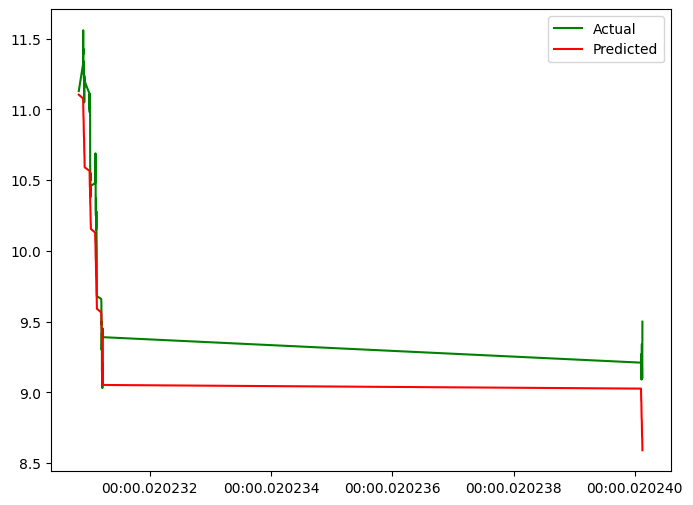

In [24]:
import matplotlib.pyplot as plt
x = dates[-99: ]
y_act = close_v[-99:]
y_pre = pd.Series(predicted_price[:-1])
plt.figure(figsize=(8,6))
plt.plot_date(x, y_act,linestyle="-",marker="None",color='g')
plt.plot_date(x, y_pre,linestyle="-",marker="None",color='r')
plt.legend(['Actual', 'Predicted'])
plt.show()
